In [1]:
import pandas as pd

# Load the CSV file
file_path = '/kaggle/input/vegi-price/Dollar-Carrot.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1459 non-null   object 
 1   Kandy          1459 non-null   float64
 2   Dambulla       1459 non-null   float64
 3   Exchange Rate  1459 non-null   float64
dtypes: float64(3), object(1)
memory usage: 45.7+ KB


(         Date   Kandy  Dambulla  Exchange Rate
 0  2020-01-01  296.43     305.0         181.50
 1  2020-01-02  267.86     272.5         181.03
 2  2020-01-03  239.29     240.0         181.37
 3  2020-01-04  210.71     207.5         181.35
 4  2020-01-05  182.14     175.0         181.34,
 None)

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the data (including Kandy, Dambulla, and Exchange Rate)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Kandy', 'Dambulla', 'Exchange Rate']])

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Input sequence
        y.append(data[i+seq_length][:2])    # Target sequence (next step)
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 30

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and test sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Display the shape of the resulting arrays
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1143, 30, 3), (286, 30, 3), (1143, 2), (286, 2))

In [3]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Check for missing values
missing_values = df.isnull().sum()

# Display the result
df.set_index('Date', inplace=True)
df = df[['Kandy', 'Dambulla', 'Exchange Rate']]  # We will focus on these two columns for LSTM
missing_values, df.head()

(Date             0
 Kandy            0
 Dambulla         0
 Exchange Rate    0
 dtype: int64,
              Kandy  Dambulla  Exchange Rate
 Date                                       
 2020-01-01  296.43     305.0         181.50
 2020-01-02  267.86     272.5         181.03
 2020-01-03  239.29     240.0         181.37
 2020-01-04  210.71     207.5         181.35
 2020-01-05  182.14     175.0         181.34)

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import mixed_precision
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

# Define a function that builds the LSTM model with hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=16, max_value=64, step=16),
                   return_sequences=True, input_shape=(seq_length, 3)))
    model.add(Dropout(hp.Float('dropout_rate1', 0.1, 0.5, step=0.1)))
    
    model.add(LSTM(units=hp.Int('units2', min_value=16, max_value=64, step=16), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_rate2', 0.1, 0.5, step=0.1)))
    
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(2, dtype='float32'))  # Output layer

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# Define a tuner using RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # The number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train per trial (to reduce variance)
    directory='my_dir',  # Directory to save search logs
    project_name='lstm_hyperparameter_tuning'
)

# Convert data to tf.data pipelines (as before)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16).prefetch(tf.data.AUTOTUNE)

# Run the hyperparameter search
tuner.search(train_dataset, epochs=20, validation_data=test_dataset, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Optionally, retrain the best model
history = best_model.fit(train_dataset, epochs=20, validation_data=test_dataset, verbose=1)


Trial 10 Complete [00h 00m 26s]
val_loss: 0.015446756035089493

Best val_loss So Far: 0.012889253441244364
Total elapsed time: 00h 03m 54s
Best Hyperparameters: {'units': 64, 'dropout_rate1': 0.1, 'units2': 32, 'dropout_rate2': 0.30000000000000004, 'dense_units': 64}
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0066 - val_loss: 0.0107
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059 - val_loss: 0.0102
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 0.0094
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0063 - val_loss: 0.0093
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0089
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - val_loss: 0.0084
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - val_loss: 0.0081
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - val_loss: 0.0083
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - val_loss: 0.0079
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - val_loss: 0.0087
Epoch 12/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - val_loss: 0.0078

In [5]:
# Make predictions on the test dataset
predictions = best_model.predict(test_dataset)

# Optionally, you can also predict on a single batch of test data:
# predictions = model.predict(X_test[:batch_size])

# Print the predictions
print(predictions)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[0.08281039 0.08142908]
 [0.08388067 0.08344988]
 [0.08458673 0.0848733 ]
 [0.08127745 0.0826146 ]
 [0.08368134 0.08515311]
 [0.08387928 0.0854956 ]
 [0.076683   0.07938599]
 [0.08332831 0.08543064]
 [0.09001818 0.09110573]
 [0.09743659 0.09706892]
 [0.09805403 0.09713665]
 [0.09685372 0.09582896]
 [0.1103074  0.10759747]
 [0.10181829 0.09952806]
 [0.25081953 0.2242854 ]
 [0.16697769 0.15896188]
 [0.12116977 0.11854462]
 [0.08657607 0.0851337 ]
 [0.14476374 0.1404896 ]
 [0.38603967 0.32686496]
 [0.52509505 0.42737252]
 [0.5109064  0.41346753]
 [0.20396715 0.1740574 ]
 [0.18566789 0.16287558]
 [0.34024996 0.28800926]
 [0.4236562  0.3544039 ]
 [0.3507224  0.29414034]
 [0.3100504  0.26167354]
 [0.2497549  0.21330185]
 [0.1883491  0.16590545]
 [0.12257856 0.12109345]
 [0.12629315 0.12509601]
 [0.15650985 0.14771089]
 [0.13598597 0.13333307]
 [0.13182046 0.12986763]
 [0.13161963 0.12966037]
 [0.1310528  0.12914333]
 [0.13065661 0.12874082]
 [0.130837

In [6]:
predictions.shape

(286, 2)

In [7]:
predictions_rescaled = scaler.inverse_transform(
    np.concatenate([predictions, np.zeros((predictions.shape[0], 1))], axis=1)
)[:, :2]

print("Rescaled Predictions:", predictions_rescaled)

Rescaled Predictions: [[120.54571696 116.44676495]
 [121.1343687  117.78554404]
 [121.52270265 118.72856375]
 [119.70259883 117.23217294]
 [121.02473564 118.91393559]
 [121.13360241 119.14083408]
 [117.17564985 115.09321732]
 [120.83056867 119.09779701]
 [124.50999655 122.85754569]
 [128.59012559 126.80815998]
 [128.92971598 126.85303325]
 [128.26954499 125.98668458]
 [135.6690675  133.78332406]
 [131.00005724 128.43733933]
 [212.95074373 211.08907349]
 [166.83772877 167.81224366]
 [141.64337255 141.03580797]
 [122.6168368  118.90107729]
 [154.62005585 155.57435546]
 [287.32182086 279.04803455]
 [363.80227506 345.63429132]
 [355.99851906 336.42223626]
 [187.18193471 177.8130237 ]
 [177.11733803 170.4050703 ]
 [262.13747561 253.30613218]
 [308.01090747 297.29259238]
 [267.89732128 257.36797452]
 [245.52771896 235.85872017]
 [212.36519814 203.81247718]
 [178.59200388 172.41235785]
 [142.41820872 142.72441193]
 [144.46123391 145.37610542]
 [161.08041555 160.35846435]
 [149.79228377 150.83

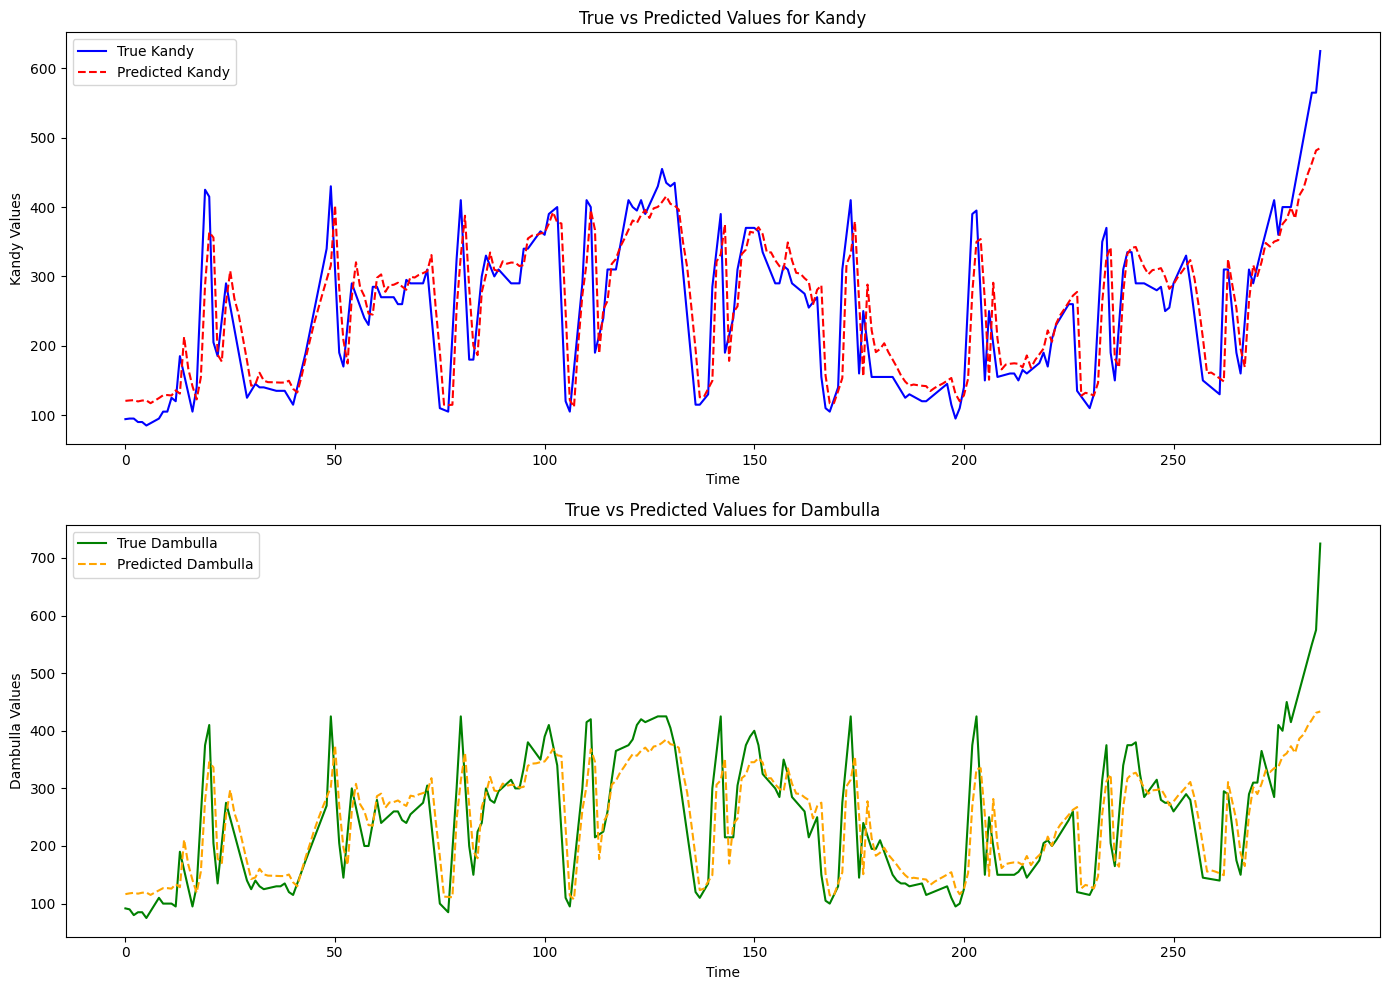

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Rescale the predictions and y_test to original scale
y_test_rescaled = scaler.inverse_transform(
    np.concatenate([y_test, np.zeros((y_test.shape[0], 1))], axis=1)
)[:, :2]



# Create two subplots for 'Kandy' and 'Dambulla'
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot for Kandy
ax[0].plot(y_test_rescaled[:, 0], color='blue', label='True Kandy')
ax[0].plot(predictions_rescaled[:, 0], color='red', linestyle='--', label='Predicted Kandy')
ax[0].set_title('True vs Predicted Values for Kandy')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Kandy Values')
ax[0].legend()

# Plot for Dambulla
ax[1].plot(y_test_rescaled[:, 1], color='green', label='True Dambulla')
ax[1].plot(predictions_rescaled[:, 1], color='orange', linestyle='--', label='Predicted Dambulla')
ax[1].set_title('True vs Predicted Values for Dambulla')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Dambulla Values')
ax[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
test_loss = best_model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Test Loss: 0.007820339873433113


In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error


# Calculate the Mean Squared Error (MSE) for each target ('Kandy' and 'Dambulla')
mse_kandy = mean_squared_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0])
mse_dambulla = mean_squared_error(y_test_rescaled[:, 1], predictions_rescaled[:, 1])

# Print the MSE results
print(f"MSE for Kandy: {mse_kandy}")
print(f"MSE for Dambulla: {mse_dambulla}")

# Calculate the RMSE for each target ('Kandy' and 'Dambulla')
rmse_kandy = np.sqrt(mean_squared_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0]))
rmse_dambulla = np.sqrt(mean_squared_error(y_test_rescaled[:, 1], predictions_rescaled[:, 1]))

# Print the RMSE results
print(f"RMSE for Kandy: {rmse_kandy}")
print(f"RMSE for Dambulla: {rmse_dambulla}")

# Calculate the RMSLE for each target ('Kandy' and 'Dambulla')
rmsle_kandy = np.sqrt(mean_squared_log_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0]))
rmsle_dambulla = np.sqrt(mean_squared_log_error(y_test_rescaled[:, 1], predictions_rescaled[:, 1]))

# Print the RMSLE results
print(f"RMSLE for Kandy: {rmsle_kandy}")
print(f"RMSLE for Dambulla: {rmsle_dambulla}")

MSE for Kandy: 2696.403913139068
MSE for Dambulla: 2952.5000907406293
RMSE for Kandy: 51.926909335517635
RMSE for Dambulla: 54.336912782570096
RMSLE for Kandy: 0.22530700174058926
RMSLE for Dambulla: 0.22661275794577992
